## Sequential feature selection

- ***Dimensionality reduction;*** Alternative way to reduce the complexity of the model and avoid overfitting.
    - ***Feature selection;*** Select a subset of the original features.
    - ***Feature extraction;*** Derive information from the feature set to construct a new feature subspace.
    
    
- The general idea of the sequential feature selection algorithms, are to select a subset of features that are most relevant to the problem. 
    - Improve computational efficiency
    - Reduce the generalization error of the model by removing noise
---

***Sequential Backward Selection (SBS)***
1. Initialize the algorithm with ```k=d``` , where ```d``` is the dimensionality of the full feature space, ```X```.
2. Determine the feature ```x``` that maximizes the criterion.
3. Remove the feature ***x*** from the feature set.
4. Terminate if ```k = number of desired eatures```, otherwise, return to ***step 2***. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations

from sklearn.base import clone
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

---

#### Load a dataset

In [2]:
# We will use the Wine, an open-source dataset available from the UCI ML library.
link = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'

df_wine = pd.read_csv(link, header=None)

wine_columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
                'Alcalinity of ash', 'Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonvlavanoid phenols', 'Proanthocyanins', 
                'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

df_wine.columns = wine_columns

from sklearn.cross_validation import train_test_split

# Assign columns [1-13] to X, and class [0] labels to y
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

# Randomly distribute 30/70 split. 30% to test, 70% to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()

# Fit the training data
X_train_std = stdsc.fit_transform(X_train)

# Use the same parameters to transofrm the test set
X_test_std = stdsc.transform(X_test)

#### SBS Algorithm implementation

In [11]:
class SBS():
    
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        
        return score

#### Create a model and fit the data

In [21]:
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train);

#### Visualization

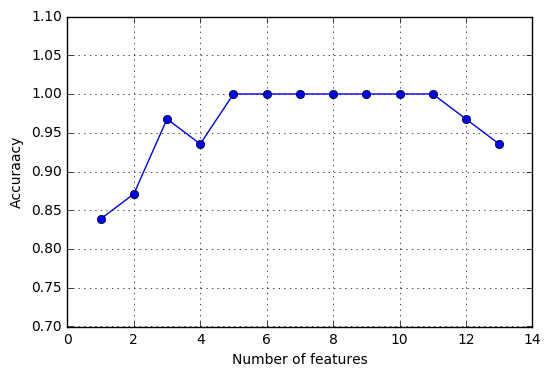

In [22]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuraacy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [16]:
# Check which of the 5 features that yielded good performance
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


#### Evaluate the performance on original

In [19]:
# Evaluate the performance of the KNN classifier on the original test set
knn.fit(X_train_std, y_train)

# Notice a slight decrease in the testset. (Example of slight overfitting)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


#### Evaluate the performance selected features

In [20]:
# Evaulate the performance on the selected 5 features only.
knn.fit(X_train_std[:, k5], y_train)

print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


Other feature selection algorithms in the scikit-learn include recursive backward elimination based on feature weights, tree-based methods to select features by importance, and univarate statistcal tests. 

Examples can be found at http://scikit-learn.org/stable/modules/feature_selection.html

## Feature Importance

Using a random forest, we can measure feature importance as the **averaged impurity decrease*** computed from all decision trees in the forest.

> Rembmer, we dont need to use standardized or normalized datasets for tree-based models

In [27]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonvlavanoid phenols           0.014645
13) Ash                            0.013916


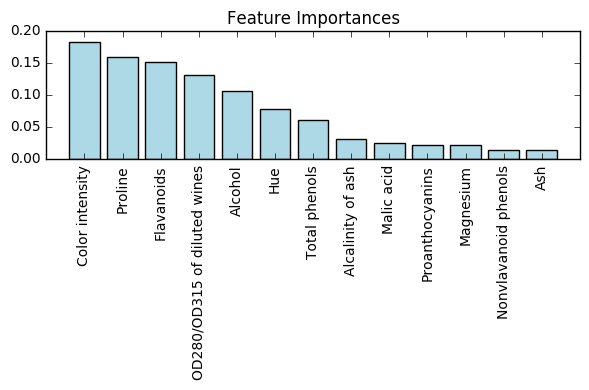

In [37]:
plt.title('Feature Importances')

plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()